### Problem Statement
The task is to predict whether a potential promotee at checkpoint in the test set will be promoted or not after the evaluation process. 

In [12]:

import pandas as pd
import numpy as np
import seaborn as sb
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import model_selection, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [13]:
train_data='D:/My Personal Documents/Learnings/Data Science/Data Sets/WNS Analytics/train_LZdllcl.csv'
test_data='D:/My Personal Documents/Learnings/Data Science/Data Sets/WNS Analytics/test_2umaH9m.csv'
train_result='D:/My Personal Documents/Learnings/Data Science/Data Sets/WNS Analytics/train_result.csv'

In [14]:
train=pd.read_csv(train_data)
test=pd.read_csv(test_data)
test_results = pd.read_csv(train_result)

In [15]:
target = 'is_promoted'
IDcol = 'employee_id'

In [16]:
train['source']='train'
test['source']='test'
data = pd.concat([train, test],ignore_index=True)
print (train.shape, test.shape, data.shape)

(54808, 15) (23490, 14) (78298, 15)


C:\Amrendra\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
data.apply(lambda x: sum(x.isnull()))

KPIs_met >80%               0
age                         0
avg_training_score          0
awards_won?                 0
department                  0
education                3443
employee_id                 0
gender                      0
is_promoted             23490
length_of_service           0
no_of_trainings             0
previous_year_rating     5936
recruitment_channel         0
region                      0
source                      0
dtype: int64

In [18]:
data.apply(lambda x: len(x.unique()))

KPIs_met >80%               2
age                        41
avg_training_score         61
awards_won?                 2
department                  9
education                   4
employee_id             78298
gender                      2
is_promoted                 3
length_of_service          35
no_of_trainings            10
previous_year_rating        6
recruitment_channel         3
region                     34
source                      2
dtype: int64

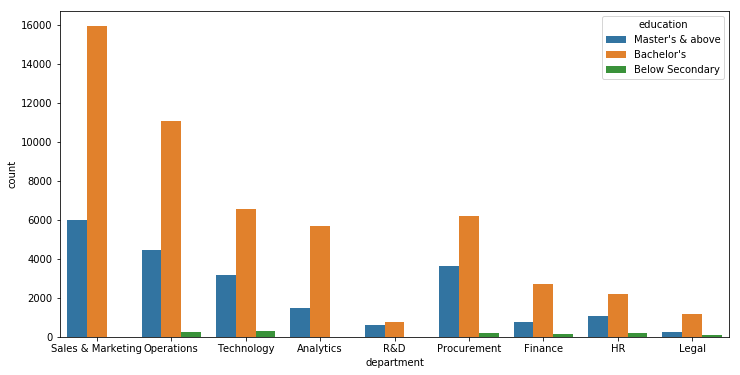

In [19]:
plt.figure(figsize=(12,6))
sb.countplot(x='department', hue='education',data=data)

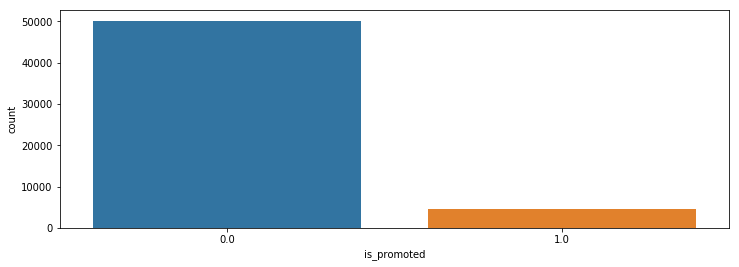

In [20]:
sb.countplot(x='is_promoted',data=data)

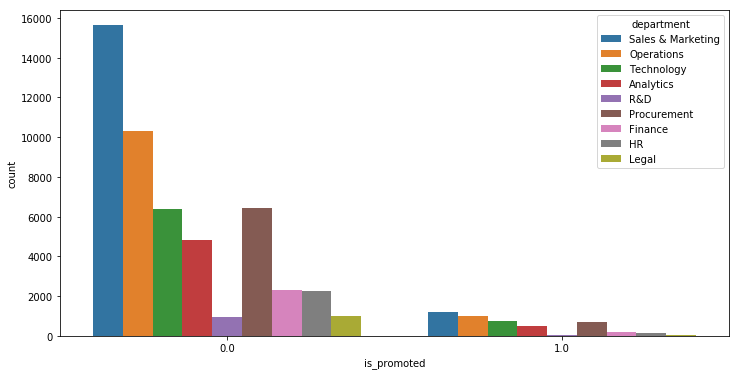

In [21]:
plt.figure(figsize=(12,6))
sb.countplot(x='is_promoted', hue='department',data=data)

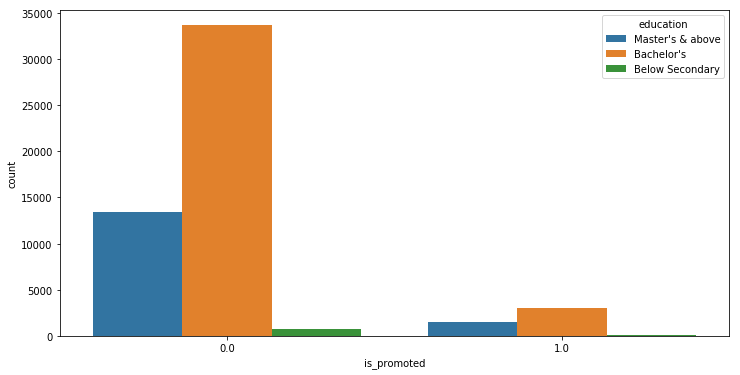

In [24]:
plt.figure(figsize=(12,6))
sb.countplot(x='is_promoted', hue='education',data=data)

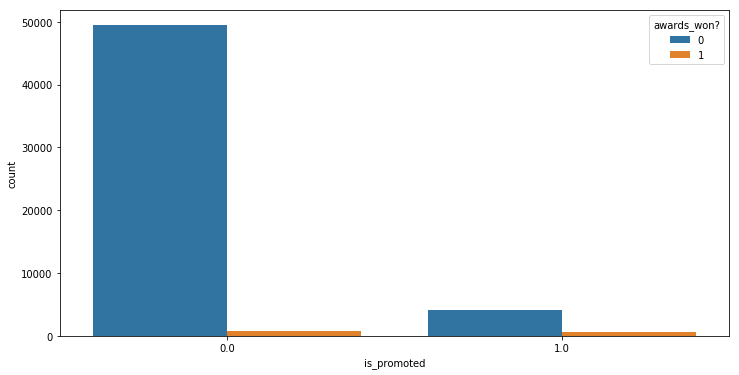

In [25]:
plt.figure(figsize=(12,6))
sb.countplot(x='is_promoted', hue='awards_won?',data=data)

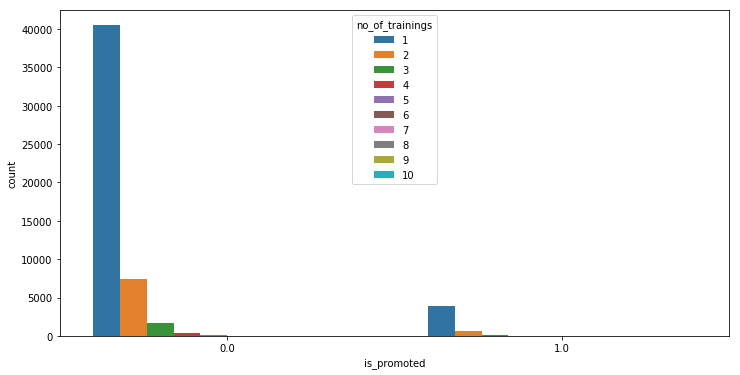

In [26]:
plt.figure(figsize=(12,6))
sb.countplot(x='is_promoted', hue='no_of_trainings',data=data)

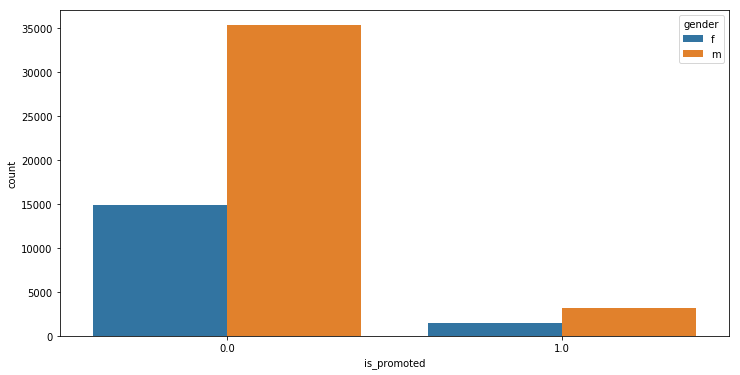

In [27]:
plt.figure(figsize=(12,6))
sb.countplot(x='is_promoted', hue='gender',data=data)

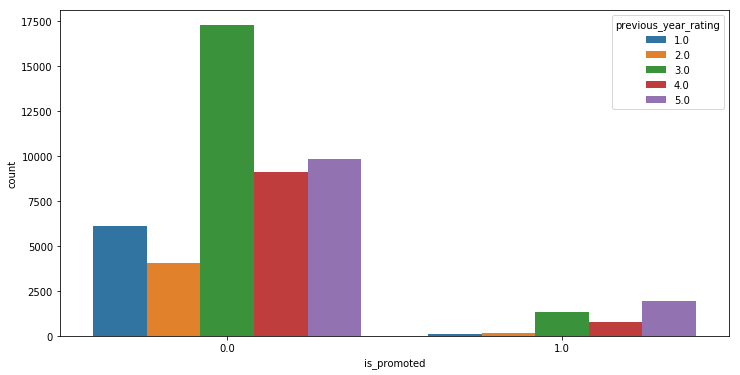

In [28]:
plt.figure(figsize=(12,6))
sb.countplot(x='is_promoted', hue='previous_year_rating',data=data)

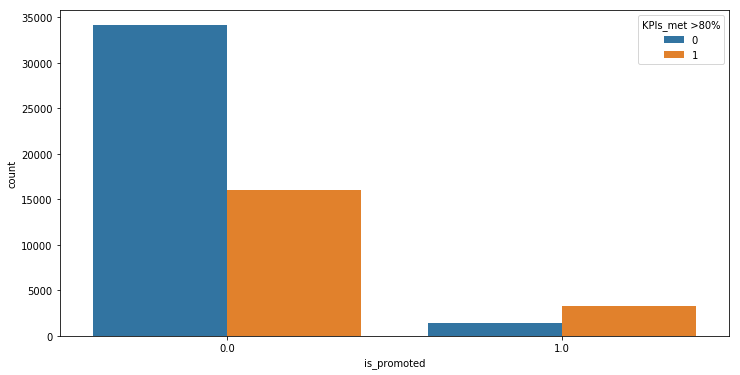

In [29]:
plt.figure(figsize=(12,6))
sb.countplot(x='is_promoted', hue='KPIs_met >80%',data=data)

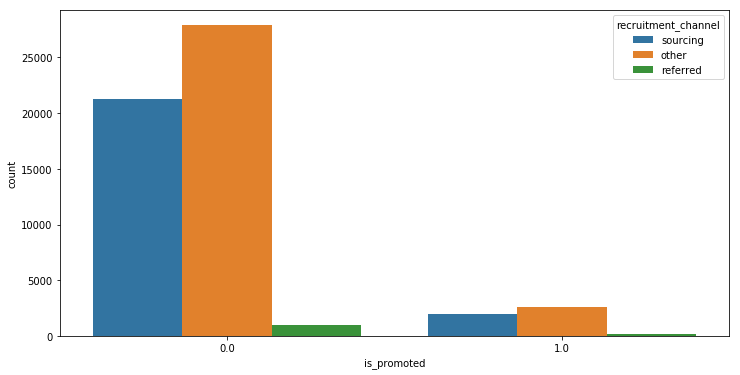

In [30]:
plt.figure(figsize=(12,6))
sb.countplot(x='is_promoted', hue='recruitment_channel',data=data)

C:\Amrendra\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


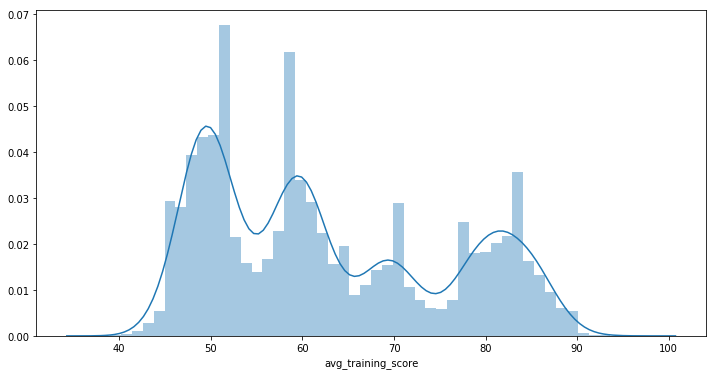

In [31]:
plt.figure(figsize=(12,6))
sb.distplot(data[data.is_promoted==0]['avg_training_score'])

In [32]:
def age_trans(age):
    if(age<30):
        return 'Young'
    elif(age>=30 and age<40):
        return 'Middle Age'
    elif(age >=40):
        return 'Senior'

In [33]:
data['age']=data['age'].apply(age_trans)

In [34]:
def rating_trans(rating): 
    if(rating>=4.0): 
        return 'High' 
    elif(rating==3.0): 
        return 'Medium' 
    elif(rating < 3.0): 
        return 'low'

In [35]:
data['previous_year_rating']=data['previous_year_rating'].apply(rating_trans)

In [36]:
data.previous_year_rating[data.previous_year_rating.isnull()]=3.0

C:\Amrendra\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
data.education[data.education.isnull()]="Bachelor's"

C:\Amrendra\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
data=pd.get_dummies(data,columns=['department','education','gender','recruitment_channel','age','previous_year_rating','region'])

In [39]:
train=data[data.source=='train']
train.drop('source',axis=1,inplace=True)
test=data[data.source=='test']
test.drop(['source','is_promoted'],axis=1,inplace=True)

C:\Amrendra\Anaconda\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [40]:
train.head()

,KPIs_met >80%,avg_training_score,awards_won?,employee_id,is_promoted,length_of_service,no_of_trainings,department_Analytics,department_Finance,department_HR,...,region_region_31,region_region_32,region_region_33,region_region_34,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9
0,1,49,0,65438,0.0,8,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,60,0,65141,0.0,4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,50,0,7513,0.0,7,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,50,0,2542,0.0,10,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,73,0,48945,0.0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
    
#     Predict on testing data:
   # dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
   # results = test_results.merge(dtest[['employee_id','predprob']], on='employee_id')
   # print ('AUC Score (Test): %f' % metrics.roc_auc_score(results[target], results['predprob']))
                
   # feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    #feat_imp.plot(kind='bar', title='Feature Importances')
   # plt.ylabel('Feature Importance Score')

In [66]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=202,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, train, test, predictors)

C:\Amrendra\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9444
AUC Score (Train): 0.932922


In [67]:
pred=xgb1.predict(test[predictors])

C:\Amrendra\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [68]:
result=pd.Series(pred.tolist()).astype(int)

In [69]:
result.to_csv('D:/My Personal Documents/Learnings/Data Science/Data Sets/WNS Analytics/final_result.csv')

In [70]:
result.value_counts()

0    22777
1      713
dtype: int64

### Below codes were used for tuning the parameters

In [18]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=5,
                                        min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=6, missing=None,
       n_estimators=177, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [19]:
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.91062, std: 0.00366, params: {'reg_alpha': 1e-05},
  mean: 0.91076, std: 0.00362, params: {'reg_alpha': 0.01},
  mean: 0.91042, std: 0.00434, params: {'reg_alpha': 0.1},
  mean: 0.91038, std: 0.00393, params: {'reg_alpha': 1},
  mean: 0.88026, std: 0.00345, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.01},
 0.9107566568610632)

In [20]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test5 = {
    'subsample':[i/100.0 for i in range(75,90,5)],
    'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=6, missing=None, n_estimators=177,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.75, 0.8, 0.85], 'colsample_bytree': [0.75, 0.8, 0.85]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [21]:

gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.90903, std: 0.00376, params: {'colsample_bytree': 0.75, 'subsample': 0.75},
  mean: 0.90971, std: 0.00366, params: {'colsample_bytree': 0.75, 'subsample': 0.8},
  mean: 0.90944, std: 0.00401, params: {'colsample_bytree': 0.75, 'subsample': 0.85},
  mean: 0.90928, std: 0.00359, params: {'colsample_bytree': 0.8, 'subsample': 0.75},
  mean: 0.90973, std: 0.00399, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.90939, std: 0.00419, params: {'colsample_bytree': 0.8, 'subsample': 0.85},
  mean: 0.90941, std: 0.00360, params: {'colsample_bytree': 0.85, 'subsample': 0.75},
  mean: 0.90942, std: 0.00343, params: {'colsample_bytree': 0.85, 'subsample': 0.8},
  mean: 0.90910, std: 0.00394, params: {'colsample_bytree': 0.85, 'subsample': 0.85}],
 {'colsample_bytree': 0.8, 'subsample': 0.8},
 0.9097252404486571)

In [110]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test2 = {
    'max_depth':[4,5,6],
    'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=2, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [4, 5, 6], 'min_child_weight': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [ ]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_